In [1]:
!pip install yfinance timesfm==1.1.0


INFO: pip is looking at multiple versions of paxml to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax[cuda12] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax[cuda12] to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is still looking at multiple versions of paxml to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warning

In [2]:
!pip install yfinance
!pip install utilsforecast


In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

In [2]:
import timesfm
import gc
import numpy as np
import pandas as pd
from timesfm import patched_decoder
from timesfm import data_loader
import yfinance as yf

2024-11-29 13:40:02.501944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
import numpy as np
import tensorflow as tf
import random
import os

# Set a seed value
seed_value = 42

# Set Python random seed
random.seed(seed_value)

# Set NumPy random seed
np.random.seed(seed_value)

# Set TensorFlow random seed
tf.random.set_seed(seed_value)

# For reproducibility in other areas, like OS operations
os.environ['PYTHONHASHSEED'] = str(seed_value)


In [4]:
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
# Loading TimesFM pretrained checkpoint
tfm = timesfm.TimesFm(
    context_len=64,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="gpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")



2024-11-29 13:40:28.724394: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.58 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 4.49 seconds.
Jitting decoding.
Jitted decoding in 21.06 seconds.


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

# انتخاب نماد سهام (مثال: AAPL برای اپل)
ticker = 'AAPL'

# بارگذاری داده‌های بورسی روزانه
data = yf.download(ticker, start='1900-01-01', end='2024-01-01')
data = data.dropna()
data.reset_index(inplace=True)  # تبدیل شاخص به ستون

# تغییر نام ستون‌ها
data.rename(columns={'Date': 'date', 'Close': 'y'}, inplace=True)



# محاسبه ویژگی‌های اضافی
data['MA_10'] = data['y'].rolling(window=10).mean()
data['MA_50'] = data['y'].rolling(window=50).mean()
data['RSI'] = 100 - (100 / (1 + data['y'].pct_change().rolling(window=14).apply(lambda x: (x[x > 0].mean() / -x[x < 0].mean()) if x[x < 0].mean() != 0 else np.inf)))



# انتخاب ستون‌های نهایی
final_cols = ["date",  "y"]
data = data[final_cols]
data.columns = data.columns.droplevel(1)

# ذخیره‌سازی داده‌ها در یک فایل CSV
data_path = 'stock_data.csv'
data.to_csv(data_path, index=False)

print(f"Number of records: {len(data)}")


[*********************100%***********************]  1 of 1 completed


Number of records: 10853


In [7]:
freq = 'D'
context_len = 64
pred_len = 1
batch_size = 32
train_data = data[data['date'] < '2022-07-01']
val_data = data[(data['date'] >= '2022-07-01') & (data['date'] < '2023-01-01')]
test_data = data[data['date'] >= '2023-01-01']


In [8]:
data.columns

Index(['date', 'y'], dtype='object', name='Price')

In [9]:
ts_cols = [col for col in data.columns if col != "date"]
cat_cols=[col for col in ts_cols if col != "y"]

num_ts = 1
# Create TimeSeriesdata loader
dtl = data_loader.TimeSeriesdata(
      data_path=data_path,
      datetime_col="date",
      num_cov_cols=None,
      cat_cov_cols=None,
      ts_cols=["y"],
      train_range=[0, len(train_data)+64],
      val_range=[len(train_data)+64, len(train_data)+len(val_data)+64],
      test_range=[len(train_data)+len(val_data)+64, len(data)],
      hist_len=context_len,
      pred_len=pred_len,
      batch_size=1,  # Change as per requirement
      freq=freq,
      normalize=False,
      epoch_len=None,
      holiday=False,
      permute=False,
  )
train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
test_batches = dtl.tf_dataset(mode="test", shift=pred_len)

2024-11-29 13:41:08.159074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-11-29 13:41:08.159338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-11-29 13:41:08.159527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-11-29 13:41:08.159688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such 

In [10]:
for tbatch in tqdm(train_batches.as_numpy_iterator()):
    pass
print(tbatch[0].shape)

655it [00:06, 101.69it/s]

(22, 1, 64)


# MAE on the test split for the pretrained TimesFM model

In [11]:
mse_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]

    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]

    mse_losses.append(np.square(forecasts - actuals).mean())

print(f"MSE: {np.mean(mse_losses)}")


186it [00:03, 56.22it/s]

MSE: 5.423287868499756


# Fine-tuning the model

In [12]:
import jax
from jax import numpy as jnp
from praxis import pax_fiddle
from praxis import py_utils
from praxis import pytypes
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from praxis import base_hyperparams
from praxis import base_layer
from paxml import tasks_lib
from paxml import trainer_lib
from paxml import checkpoints
from paxml import learners
from paxml import partitioning
from paxml import checkpoint_types

In [13]:
NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate
LayerTpl = pax_fiddle.Config[base_layer.BaseLayer]
AuxLossStruct = base_layer.AuxLossStruct

AUX_LOSS = base_layer.AUX_LOSS
template_field = base_layer.template_field

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)

In [14]:
model = pax_fiddle.Config(
    patched_decoder.PatchedDecoderFinetuneModel,
    name='patched_decoder_finetune',
    core_layer_tpl=tfm.model_p,
)

In [15]:

@pax_fiddle.auto_config
def build_learner() -> learners.Learner:
  return pax_fiddle.Config(
      learners.Learner,
      name='learner',
      loss_name='avg_qloss',
      optimizer=optimizers.Adam(
          epsilon=1e-7,
          clip_threshold=1e2,
          learning_rate=1e-2,
          lr_schedule=pax_fiddle.Config(
              schedules.Cosine,
              initial_value=1e-3,
              final_value=1e-4,
              total_steps=40000,
          ),
          ema_decay=0.9999,
      ),
      # Linear probing i.e we hold the transformer layers fixed.
      bprop_variable_exclusion=['.*/stacked_transformer_layer/.*'],
  )

In [16]:

task_p = tasks_lib.SingleTask(
    name='ts-learn',
    model=model,
    train=tasks_lib.SingleTask.Train(
        learner=build_learner(),
    ),
)

In [17]:
task_p.model.ici_mesh_shape = [1, 1, 1]
task_p.model.mesh_axis_names = ['replica', 'data', 'mdl']

DEVICES = np.array(jax.devices()).reshape([1, 1, 1])
MESH = jax.sharding.Mesh(DEVICES, ['replica', 'data', 'mdl'])

num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')

num_devices: 1
device kind: Tesla T4


In [18]:
jax_task = task_p
key, init_key = jax.random.split(key)

# To correctly prepare a batch of data for model initialization (now that shape
# inference is merged), we take one devices*batch_size tensor tuple of data,
# slice out just one batch, then run the prepare_input_batch function over it.


def process_train_batch(batch):

    past_ts = batch[0].reshape(len(batch[2]) * num_ts, -1)
    actual_ts = batch[3].reshape(len(batch[2]) * num_ts, -1)
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


def process_eval_batch(batch):
    past_ts = batch[0]
    actual_ts = batch[3]
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


jax_model_states, _ = trainer_lib.initialize_model_state(
    jax_task,
    init_key,
    process_train_batch(tbatch),
    checkpoint_type=checkpoint_types.CheckpointType.GDA,
)

In [19]:
jax_model_states.mdl_vars['params']['core_layer'] = tfm._train_state.mdl_vars['params']
jax_vars = jax_model_states.mdl_vars
gc.collect()

0

In [20]:
jax_task = task_p


def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(
      jax_task, states, prng_key, inputs
  )


def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(
      jax_task, states, prng_key, inputs
  )

key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

p_train_step = jax.pmap(train_step, axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')

In [21]:
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars

In [22]:
best_eval_loss = 1e7
step_count = 0
patience = 0
NUM_EPOCHS = 100
PATIENCE = 5
TRAIN_STEPS_PER_EVAL = 1000
CHECKPOINT_DIR='/content'

In [23]:
def reshape_batch_for_pmap(batch, num_devices):
  def _reshape(input_tensor):
    bsize = input_tensor.shape[0]
    residual_shape = list(input_tensor.shape[1:])
    nbsize = bsize // num_devices
    return jnp.reshape(input_tensor, [num_devices, nbsize] + residual_shape)

  return jax.tree.map(_reshape, batch)

In [24]:
!rm -rf /content/checkpoint*


In [25]:
import numpy as np
import jax
import matplotlib.pyplot as plt
import re

def traverse_params(var_dict, prefix='', param_paths=None):
    """Recursively traverse the parameter tree and collect parameter paths."""
    if param_paths is None:
        param_paths = []
    for key, value in var_dict.items():
        full_key = f'{prefix}/{key}' if prefix else key
        if isinstance(value, dict):
            traverse_params(value, prefix=full_key, param_paths=param_paths)
        else:
            param_paths.append(full_key)
    return param_paths

def is_trainable(param_path, exclusion_patterns):
    """Determine if a parameter is trainable based on exclusion patterns."""
    for pattern in exclusion_patterns:
        if re.match(pattern, param_path):
            return False
    return True

def count_trainable_params(var_dict, exclusion_patterns):
    """Count trainable parameters based on exclusion patterns."""
    param_paths = traverse_params(var_dict)
    trainable_param_paths = [p for p in param_paths if is_trainable(p, exclusion_patterns)]

    # Count parameters
    param_counts = {}
    total_trainable_params = 0
    for path in trainable_param_paths:
        # Retrieve the parameter value by path
        parts = path.split('/')
        param_value = var_dict
        for part in parts:
            param_value = param_value[part]
        num_params = np.prod(param_value.shape)
        param_counts[path] = num_params
        total_trainable_params += num_params

    return param_counts, total_trainable_params, trainable_param_paths

def calculate_changes_for_trainable(initial_vars, fine_tuned_vars, trainable_param_paths):
    """Calculate changes only for trainable parameters."""
    changes = {}
    for path in trainable_param_paths:
        # Retrieve parameter values
        parts = path.split('/')
        initial_value = initial_vars
        fine_tuned_value = fine_tuned_vars
        for part in parts:
            initial_value = initial_value[part]
            fine_tuned_value = fine_tuned_value[part]
        # Compute absolute change
        diff = np.abs(fine_tuned_value - initial_value)
        total_change = diff.sum()
        changes[path] = total_change
    return changes


In [26]:
def count_params(var_dict, prefix=''):
    """Recursively count the total number of parameters for each component."""
    param_counts = {}
    total_params = 0
    for key, value in var_dict.items():
        full_key = f'{prefix}/{key}' if prefix else key
        if isinstance(value, dict):
            sub_counts, sub_total = count_params(value, prefix=full_key)
            param_counts.update(sub_counts)
            total_params += sub_total
        else:
            num_params = np.prod(value.shape)
            param_counts[full_key] = num_params
            total_params += num_params
    return param_counts, total_params



# Step 1: Save initial weights before fine-tuning
initial_weights = jax.device_get(jax_model_states.mdl_vars['params'])
initial_param_counts, total_initial_params = count_params(initial_weights)
print(f"Initial parameter counts: {initial_param_counts}")
print(f"Total initial parameters: {total_initial_params}")

Initial parameter counts: {'core_layer/freq_emb/emb_var': 3840, 'core_layer/horizon_ff_layer/hidden_layer/bias/b': 1280, 'core_layer/horizon_ff_layer/hidden_layer/linear/w': 1638400, 'core_layer/horizon_ff_layer/output_layer/bias/b': 1280, 'core_layer/horizon_ff_layer/output_layer/linear/w': 1638400, 'core_layer/horizon_ff_layer/residual_layer/bias/b': 1280, 'core_layer/horizon_ff_layer/residual_layer/linear/w': 1638400, 'core_layer/input_ff_layer/hidden_layer/bias/b': 1280, 'core_layer/input_ff_layer/hidden_layer/linear/w': 81920, 'core_layer/input_ff_layer/output_layer/bias/b': 1280, 'core_layer/input_ff_layer/output_layer/linear/w': 1638400, 'core_layer/input_ff_layer/residual_layer/bias/b': 1280, 'core_layer/input_ff_layer/residual_layer/linear/w': 81920, 'core_layer/stacked_transformer_layer/x_layers_0/ff_layer/ffn_layer1/bias/b': 1280, 'core_layer/stacked_transformer_layer/x_layers_0/ff_layer/ffn_layer1/linear/w': 1638400, 'core_layer/stacked_transformer_layer/x_layers_0/ff_layer

In [27]:
exclusion_patterns = [r'.*/stacked_transformer_layer/.*']

# Step 2: Count trainable parameters
trainable_param_counts, total_trainable_params, trainable_param_paths = count_trainable_params(initial_weights, exclusion_patterns)
print(f"Trainable parameter counts per component:\n{trainable_param_counts}")
print(f"Total trainable parameters: {total_trainable_params}")

Trainable parameter counts per component:
{'core_layer/freq_emb/emb_var': 3840, 'core_layer/horizon_ff_layer/hidden_layer/bias/b': 1280, 'core_layer/horizon_ff_layer/hidden_layer/linear/w': 1638400, 'core_layer/horizon_ff_layer/output_layer/bias/b': 1280, 'core_layer/horizon_ff_layer/output_layer/linear/w': 1638400, 'core_layer/horizon_ff_layer/residual_layer/bias/b': 1280, 'core_layer/horizon_ff_layer/residual_layer/linear/w': 1638400, 'core_layer/input_ff_layer/hidden_layer/bias/b': 1280, 'core_layer/input_ff_layer/hidden_layer/linear/w': 81920, 'core_layer/input_ff_layer/output_layer/bias/b': 1280, 'core_layer/input_ff_layer/output_layer/linear/w': 1638400, 'core_layer/input_ff_layer/residual_layer/bias/b': 1280, 'core_layer/input_ff_layer/residual_layer/linear/w': 81920}
Total trainable parameters: 6728960


In [28]:
states_fine_tune=None

In [29]:
for epoch in range(NUM_EPOCHS):
    print(f"__________________Epoch: {epoch}__________________", flush=True)

    # Train phase
    train_its = train_batches.as_numpy_iterator()
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break

    train_losses = []  # Initialize train losses for the epoch
    for batch in train_its:
        if patience >= PATIENCE:
            print("Early stopping.", flush=True)
            break

        tbatch = process_train_batch(batch)
        tbatch = reshape_batch_for_pmap(tbatch, num_devices)
        replicated_jax_states, step_fun_out = p_train_step(
            replicated_jax_states, train_prng_seed, tbatch
        )
        train_losses.append(step_fun_out.loss[0])

        # Increment step count
        step_count += 1

    # Calculate and print average train loss for the epoch
    avg_train_loss = np.mean(train_losses)
    print(f"Train loss at end of epoch {epoch}: {avg_train_loss}", flush=True)

    # Eval phase at the end of the epoch
    print("Starting eval.", flush=True)
    val_its = val_batches.as_numpy_iterator()
    eval_losses = []  # Initialize eval losses for the epoch

    for ev_batch in tqdm(val_its):
        ebatch = process_eval_batch(ev_batch)
        ebatch = reshape_batch_for_pmap(ebatch, num_devices)
        _, step_fun_out = p_eval_step(replicated_jax_states, eval_prng_seed, ebatch)
        eval_losses.append(step_fun_out.loss[0])

    # Calculate and print average eval loss for the epoch
    mean_loss = np.mean(eval_losses)
    print(f"Eval loss at end of epoch {epoch}: {mean_loss}", flush=True)

    # Check for checkpoint saving and patience logic
    if mean_loss < best_eval_loss or np.isnan(mean_loss):
        best_eval_loss = mean_loss
        print("Saving checkpoint.")
        jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
            replicated_jax_states
        )
        states_fine_tune=replicated_jax_states
        checkpoints.save_checkpoint(
            jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
        )
        patience = 0  # Reset patience since we improved
        del jax_state_for_saving
        gc.collect()
    else:
        patience += 1
        print(f"patience: {patience}")

    # Early stopping check
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break


__________________Epoch: 0__________________
Train loss at end of epoch 0: 2.3633310794830322
Starting eval.


127it [00:13,  9.55it/s]


Eval loss at end of epoch 0: 27.935487747192383


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


__________________Epoch: 1__________________
Train loss at end of epoch 1: 2.1030917167663574
Starting eval.


127it [00:01, 103.74it/s]


Eval loss at end of epoch 1: 27.82087516784668


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.
__________________Epoch: 2__________________
Train loss at end of epoch 2: 1.958559513092041
Starting eval.


127it [00:01, 103.25it/s]

Eval loss at end of epoch 2: 27.622390747070312



        shapes of train_state  as the unpadded shapes.


Saving checkpoint.
__________________Epoch: 3__________________
Train loss at end of epoch 3: 1.8314744234085083
Starting eval.


127it [00:01, 103.24it/s]


Eval loss at end of epoch 3: 27.297916412353516


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.
__________________Epoch: 4__________________
Train loss at end of epoch 4: 1.724226951599121
Starting eval.


127it [00:01, 103.31it/s]

Eval loss at end of epoch 4: 26.721813201904297



        shapes of train_state  as the unpadded shapes.


Saving checkpoint.
__________________Epoch: 5__________________
Train loss at end of epoch 5: 1.6332553625106812
Starting eval.


127it [00:01, 102.75it/s]

Eval loss at end of epoch 5: 26.867652893066406
patience: 1
__________________Epoch: 6__________________


Train loss at end of epoch 6: 1.552759051322937
Starting eval.


127it [00:01, 103.78it/s]

Eval loss at end of epoch 6: 27.2678279876709
patience: 2
__________________Epoch: 7__________________


Train loss at end of epoch 7: 1.4658087491989136
Starting eval.


127it [00:01, 103.82it/s]

Eval loss at end of epoch 7: 27.654085159301758
patience: 3
__________________Epoch: 8__________________


Train loss at end of epoch 8: 1.4137868881225586
Starting eval.


127it [00:01, 103.80it/s]

Eval loss at end of epoch 8: 27.65414047241211
patience: 4
__________________Epoch: 9__________________


Train loss at end of epoch 9: 1.3478139638900757
Starting eval.


127it [00:01, 102.43it/s]


Eval loss at end of epoch 9: 29.05936050415039
patience: 5
Early stopping.


In [30]:
train_state = checkpoints.restore_checkpoint(jax_model_states, CHECKPOINT_DIR)

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


In [31]:

fine_tuned_weights = jax.device_get(states_fine_tune.mdl_vars['params'])
# Since replicated_jax_states are replicated across devices, extract one replica
fine_tuned_weights = jax.tree_util.tree_map(lambda x: x[0], fine_tuned_weights)

# Step 3: Calculate changes for trainable parameters
param_changes = calculate_changes_for_trainable(initial_weights, fine_tuned_weights, trainable_param_paths)
print(f"Parameter changes for trainable components:\n{param_changes}")

Parameter changes for trainable components:
{'core_layer/freq_emb/emb_var': 0.7726112, 'core_layer/horizon_ff_layer/hidden_layer/bias/b': 0.4066086, 'core_layer/horizon_ff_layer/hidden_layer/linear/w': 919.2629, 'core_layer/horizon_ff_layer/output_layer/bias/b': 0.0003345972, 'core_layer/horizon_ff_layer/output_layer/linear/w': 4.2500525, 'core_layer/horizon_ff_layer/residual_layer/bias/b': 0.0003345533, 'core_layer/horizon_ff_layer/residual_layer/linear/w': 5.9185658, 'core_layer/input_ff_layer/hidden_layer/bias/b': 0.8268473, 'core_layer/input_ff_layer/hidden_layer/linear/w': 16.944689, 'core_layer/input_ff_layer/output_layer/bias/b': 0.77261484, 'core_layer/input_ff_layer/output_layer/linear/w': 1085.1875, 'core_layer/input_ff_layer/residual_layer/bias/b': 0.77261513, 'core_layer/input_ff_layer/residual_layer/linear/w': 17.665085}


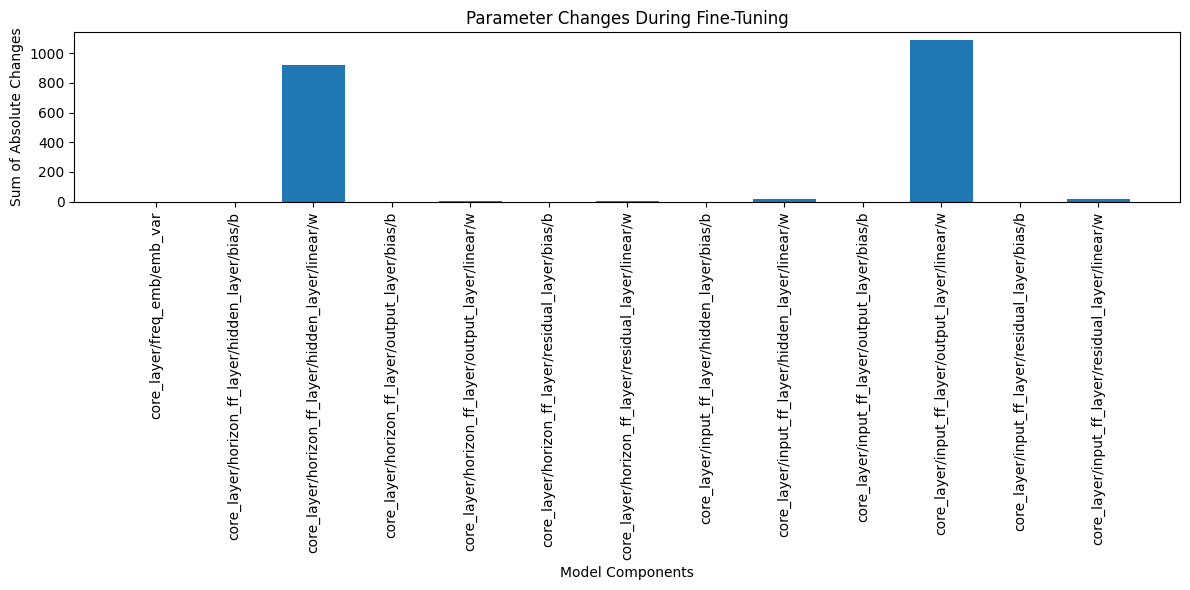

In [32]:
components = list(param_changes.keys())
changes = [param_changes[comp] for comp in components]

plt.figure(figsize=(12, 6))
plt.bar(components, changes)
plt.xticks(rotation=90)
plt.title("Parameter Changes During Fine-Tuning")
plt.ylabel("Sum of Absolute Changes")
plt.xlabel("Model Components")
plt.tight_layout()
plt.show()

In [33]:
# Identify non-trainable parameters
all_param_paths = traverse_params(initial_weights)
non_trainable_param_paths = [p for p in all_param_paths if not is_trainable(p, exclusion_patterns)]

# Calculate changes for non-trainable parameters
non_trainable_changes = calculate_changes_for_trainable(initial_weights, fine_tuned_weights, non_trainable_param_paths)

# Check if all changes are zero
non_trainable_non_zero = {k: v for k, v in non_trainable_changes.items() if v != 0}
if not non_trainable_non_zero:
    print("All non-trainable parameters remained unchanged.")
else:
    print("Some non-trainable parameters have changed:")
    # pprint.pprint(non_trainable_non_zero)


All non-trainable parameters remained unchanged.


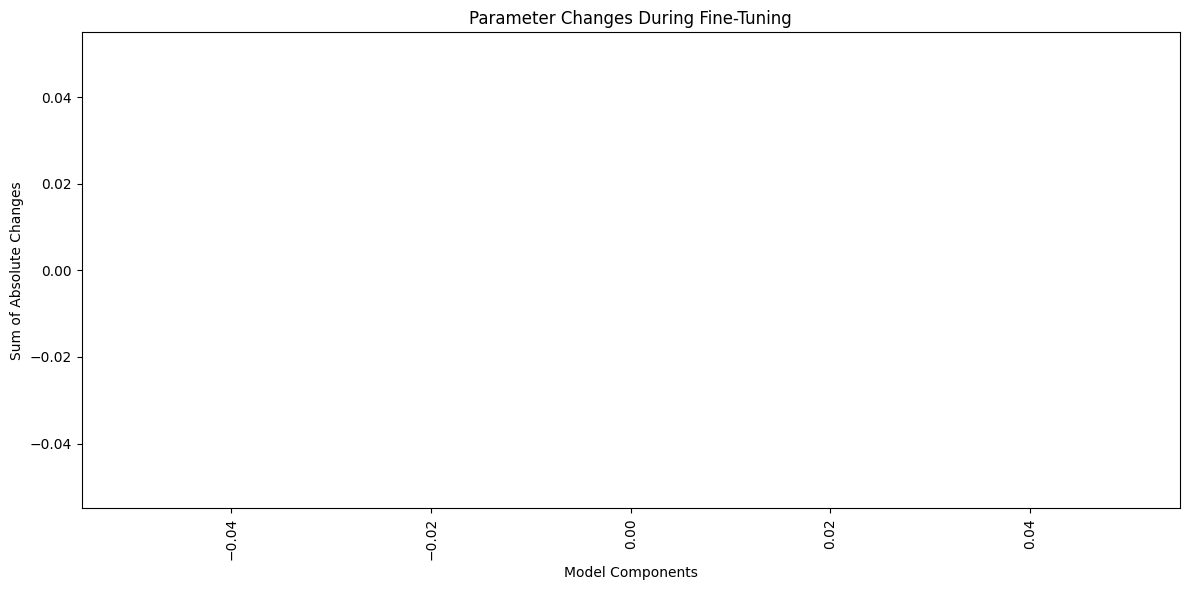

In [34]:
components = list(non_trainable_non_zero.keys())
changes = [non_trainable_non_zero[comp] for comp in components]

plt.figure(figsize=(12, 6))
plt.bar(components, changes)
plt.xticks(rotation=90)
plt.title("Parameter Changes During Fine-Tuning")
plt.ylabel("Sum of Absolute Changes")
plt.xlabel("Model Components")
plt.tight_layout()
plt.show()

In [35]:
non_trainable_non_zero

{}

In [41]:
        jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
            states_fine_tune
        )

        checkpoints.save_checkpoint(
            jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
        )

        shapes of train_state  as the unpadded shapes.


In [ ]:

print(train_state.step)
tfm._train_state.mdl_vars['params'] = train_state.mdl_vars['params']['core_layer']
tfm.jit_decode()

3275
Jitting decoding.


In [ ]:
mse_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]
    mse_losses.append(np.square(forecasts - actuals))

print(f"Mse: {np.mean(mse_losses)}")